In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np
from collections import Counter
from typing import List

from PIL import Image

# Game of live game functions

In [2]:
def normalize_x(x):
    return x % width

def normalize_y(y):
    return y % height

def run(world, n):
    for gen in range(n):
        world = next_generation(world)
    return world

def next_generation(world):
    possible_cells = counts = neighbour_count(world)
    return {
        cell for cell in possible_cells if (counts[cell]==3) or (counts[cell]==2 and cell in world)
    }

def neighbour_count(world):
    return Counter(neighbour for cell in world for neighbour in neighbours(cell))

def neighbours(cell):
    (x, y) = cell
    return [
        (normalize_x(x-1), normalize_y(y-1)),  (x, normalize_y(y-1)), (normalize_x(x+1), normalize_y(y-1)),
        (normalize_x(x-1), y), (normalize_x(x+1), y),
        (normalize_x(x-1), normalize_y(y+1)), (x, normalize_y(y+1)), (normalize_x(x+1), normalize_y(y+1))
    ]
    
def create_random_world(number_of_cells=100):
    world = set()
    for c in range(number_of_cells):
        x = np.random.randint(0, width)
        y = np.random.randint(0, height)
        cell = (x, y)
        if cell not in world:
            world.add(cell)
    print('Created world with {} cells.'.format(len(world)))
    return world

def run(world, generations=100):
    worlds = []
    for gen in range(generations):
        world = next_generation(world)
        worlds.append(world)
    print('Finished {} generations'.format(generations))
    return worlds


## Execution

In [3]:
width = 100
height = 50

total_number_of_inital_cells = 2000
total_number_of_generations = 1000

world = create_random_world(total_number_of_inital_cells)
generations = run(world, total_number_of_generations)

Created world with 1641 cells.
Finished 1000 generations


# Visualization class

In [6]:
class GameOfLiveVisualizer(object):
    def __init__(self, generations: List[list]):
        self._width = 100
        self._height = 50
        
        self._generations = generations
        self._current_generation_index = 0
        self._population_per_generation = [len(generation) for generation in generations]
        
        self._init_chart()
        
    @property
    def current_generation_index(self):
        return self._current_generation_index
    
    @current_generation_index.setter
    def current_generation_index(self, generation_index):
        max_generation = len(self._population_per_generation)
        self._current_generation_index = max(min(generation_index, max_generation), 0)
        self._update()
        
    def _init_chart(self):
        # Total population chart
        _, self._population_chart_ax = plt.subplots()
        population_chart = self._population_chart_ax.plot(self._population_per_generation)
        self._generation_marker = self._population_chart_ax.axvline(x=self._current_generation_index, color='red')
        self._population_chart_out = widgets.Output()
        with self._population_chart_out:
            plt.show(self._population_chart_ax.figure)
            
        # World as image
        _, self._world_chart_ax = plt.subplots()
        cm = matplotlib.colors.ListedColormap([(220/255, 220/255, 220/255), (100/255, 0, 0), (0, 140/255, 0), (0,0,0)],)
        self._world_chart = self._world_chart_ax.imshow(self._get_current_generation_world_image(), cmap=cm, vmin=0, vmax=1)
        self._world_chart_out = widgets.Output()
        with self._world_chart_out:
            plt.show(self._world_chart_ax.figure)
            
        # Generation selection slider and buttons
        self._generation_slider = widgets.IntSlider(min=0, max=len(self._population_per_generation), value=self._current_generation_index, description='Generation')
        next_generation_button = widgets.Button(description='Next')
        prev_generation_button = widgets.Button(description='Previous')
        
        # Bind event handlers
        self._generation_slider.observe(self._generation_slider_change, names='value')
        next_generation_button.on_click(self._goto_next_generation)
        prev_generation_button.on_click(self._goto_previous_generation)
        
        # Compose layout
        grid = widgets.GridspecLayout(1, 3)
        grid[0, 0] = self._population_chart_out
        grid[0, 1] = self._world_chart_out
        grid[0, 2] = widgets.VBox([self._generation_slider, widgets.HBox([prev_generation_button, next_generation_button])])
        display(grid)
            
    def _generation_slider_change(self, value_change):
        self.current_generation_index = value_change.new
    
    def _goto_next_generation(self, button):
        self.current_generation_index += 1
        
    def _goto_previous_generation(self, button):
        self.current_generation_index -= 1
            
    def _get_generation_world_image(self, generation_index):
        img = np.zeros((self._height, self._width))
        for cell in self._generations[generation_index]:
            (x,y) = cell
            img[y][x] = 1
        return img
            
    def _get_current_generation_world_image(self):
        return self._get_generation_world_image(self._current_generation_index)
    
    def _update(self):
        # Update slider value
        self._generation_slider.value = self.current_generation_index
        
        # Update generation marker
        self._generation_marker.set_xdata(self._current_generation_index)
        with self._population_chart_out:
            self._population_chart_out.clear_output(wait=True)
            display(self._population_chart_ax.figure)
            
        # Update world image
        self._world_chart.set_data(self._get_current_generation_world_image())
        with self._world_chart_out:
            self._world_chart_out.clear_output(wait=True)
            display(self._world_chart_ax.figure)
            
    def ex(self):
        total = len(self._population_per_generation)
        images = []
        for i in range(total):
            data = self._get_generation_world_image(i)
            self._world_chart.set_data(data)
            with self._world_chart_out:
                self._world_chart_out.clear_output(wait=True)
                display(self._world_chart_ax.figure)            
            i = Image.new('RGB', (100, 50))
            i.frombytes(self._world_chart.to_rgba(data, bytes=True, norm=True))
            images.append(i)
        images[0].save('animation.gif', format='GIF', append_images=images[1:], save_all=True, duration=100, loop=0)
        
        

## Visualize

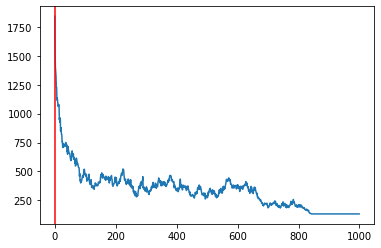

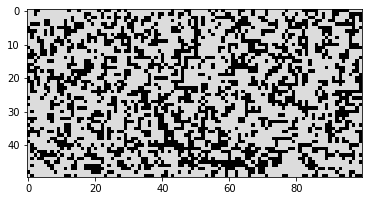

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

In [7]:
viz = GameOfLiveVisualizer(generations)

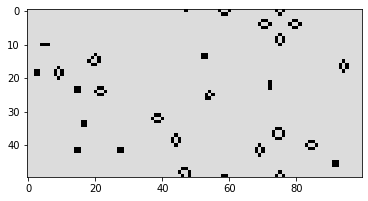

In [23]:
viz.ex()